In [75]:
import sys
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [76]:
def getTrainList() ->list[str]:
    trainList = os.listdir("../CCPD_SubDataset/CCPD_SubDataset/train/")
    #trainList.remove('extraction')
    return trainList

In [77]:
def parse_info(nom : str)->dict:
    info = {}
    l = nom.split('-')
    coordAnglesPlaque = []
    for coord in l[3].split('_'):
        coord = coord.split("&")
        coordAnglesPlaque.append([int(coo) for coo in coord])
    info['cooAngle']= np.array(coordAnglesPlaque)


    info['carac'] = [int(char) for char in l[4].split('_')[2:]]
    return nom,info

In [78]:
def parseNameList(nameList : list[str]) -> dict:
    infoGlobal = {}
    for name in nameList :
        nom, info = parse_info(name)
        infoGlobal[nom] = info
    return infoGlobal

In [79]:
"""dic = parseNameList(trainList)

print(parseNameList(trainList))"""

'dic = parseNameList(trainList)\n\nprint(parseNameList(trainList))'

In [94]:
def computeHomographie(nom : str, dic : dict) -> np.ndarray:
    im = cv.cvtColor(cv.imread(f"../CCPD_SubDataset/CCPD_SubDataset/train/{nom}"),cv.COLOR_BGR2GRAY)
    h, status = cv.findHomography(dic[nom]['cooAngle'],np.array([[110,35],[0,35],[0,0],[110,0]]))
    im_dst = cv.warpPerspective(im,h,(111,36))
    return im_dst

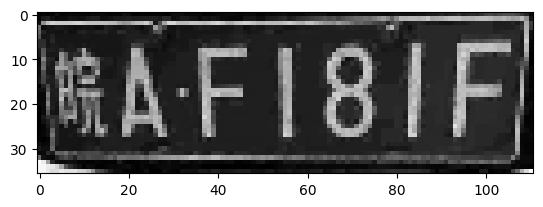

In [81]:
img = computeHomographie('047974137931-92_80-44&405_446&537-447&539_68&518_49&407_428&428-0_0_5_25_32_25_5-62-307.jpg',dic)

plt.imshow(img,cmap='gray')

In [111]:
def binarize(img : np.ndarray, seuil = 120):
    imgFinal = []
    minLigne = 5
    maxLigne = 27
    minCol = 35
    maxCol = 105

    for num,ligne in enumerate(img):
        lign = [0 if (i < seuil or num < minLigne or num > maxLigne or col < minCol or col > maxCol) else 255 for col,i in enumerate(ligne)]
        imgFinal.append(lign)
    imgFinal = np.array(imgFinal)
    plt.imshow(imgFinal,cmap='gray')
    return imgFinal

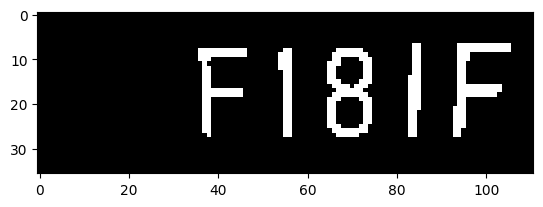

In [83]:
imgFinal = binarize(img)

In [84]:
def computeHorizontalProfil(imgFinal):
    hist = [0] *111
    for ligne in imgFinal :
        for index,val in enumerate(ligne):
            hist[index] = hist[index] + val
    return hist

In [85]:
def lookForColumnLetter(hist):
    IOList = []
    isLetter = False
    startLetter = 0
    for index, val in enumerate(hist):
        if isLetter:
            if val == 0:
                isLetter = False
                IOList.append((startLetter,index))
        else:
            if val != 0:
                isLetter = True
                startLetter = index
    return IOList

In [86]:
def lookForLetter(IOList,imgFinal):
    infoLetter = [] #point de départ et hauteur et largeur
    hist = [0] * 36
    for min,max in IOList:
        hist = [0] * 36
        for numLigne,ligne in enumerate(imgFinal):
            for colone in range(min,max+1):
                hist[numLigne] = hist[numLigne] + ligne[colone]

        #plt.plot(hist)

        isLetter = False
        startLetter = 0
        for index, val in enumerate(hist):
            if isLetter:
                if val == 0:
                    isLetter = False
                    infoLetter.append(((min,startLetter),(index-startLetter,max-min))) #(xdep, ydep),(hauteur,largeur)
            else:
                if val != 0:
                    isLetter = True
                    startLetter = index
    return infoLetter

In [87]:
ioList = lookForColumnLetter(hist)

print(ioList)

[(36, 47), (54, 57), (65, 75), (83, 86), (93, 106)]


In [88]:
letters = lookForLetter(ioList,imgFinal)

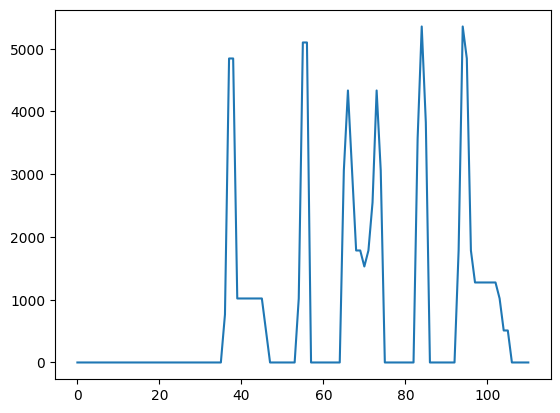

In [89]:
plt.plot(hist)

TODO :

sauvegarder les info de la position des boxs autours des lettres

In [124]:
def saveImg(img,nom,letters:list[tuple[tuple[int,int],tuple[int,int]]],dict):
    if len(letters) < 5 :
        return
    ID = nom.split('-')[0]
    listCaract = dict[nom]['carac']
    if not os.path.isdir(f"../DataTest/extraction/{ID}"):
        os.mkdir(f"../DataTest/extraction/{ID}")
    
    for index,val in enumerate(zip(letters,listCaract)):
        letter,caract = val
        coo,dimention = letter
        x,y = coo
        h,l = dimention
        x2 = x + l
        y2 = y+h
        newImg = img[y:y2,x:x2]
        
        cv.imwrite(f"../DataTest/extraction/{ID}/{index}-{caract}.jpg",newImg)
        #plt.imshow(newImg,cmap='gray')


In [91]:
#name = '047974137931-92_80-44&405_446&537-447&539_68&518_49&407_428&428-0_0_5_25_32_25_5-62-307.jpg'
#saveImg(imgFinal,name,letters,dic)

In [92]:
def main():
    trainList = getTrainList()

    dic = parseNameList(trainList)

    for imgName in dic.keys():
        img = computeHomographie(imgName,dic)
        imgBin = binarize(img)
        
        #Creation des profils horizontaux et verticaux
        hist = computeHorizontalProfil(imgBin)
        ioList = lookForColumnLetter(hist)
        #Localisation des lettres
        letters = lookForLetter(ioList,imgBin)
        saveImg(imgBin,imgName,letters,dic)

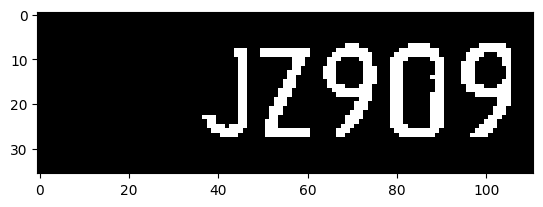

In [95]:
main()

In [117]:
def computeOhmegaBackground(T : int, histo):
    sum = 0
    for i in range(T+1):
        sum += histo[i]
    return sum

def computeMu(ohmega, borneMin, borneMax, histo):
    sum = 0
    #print(borneMax)
    for i in range(borneMin,borneMax):
        sum += i * histo[i]
    return sum/ohmega

def Otsu(histo):
    sigma2Bmax = 0
    Tmax = 0
    for T in range(255):
        ohmB = computeOhmegaBackground(T,histo)
        ohmF = 1- ohmB

        muB = computeMu(ohmB,0,T,histo)
        muF = computeMu(ohmF,T+1,255,histo)

        sigma2B = ohmB*ohmF*(muB-muF)**2
       
        if sigma2B > sigma2Bmax:
            sigma2Bmax = sigma2B
            Tmax = T
    return Tmax

def getHisto(img):
    imgsplit = cv.split(img)
    return cv.calcHist(imgsplit,[0],None,[255],(0,256))


C:\Users\slefebvr\AppData\Local\Temp\ipykernel_10868\30868993.py:12: RuntimeWarning: invalid value encountered in true_divide
  return sum/ohmega


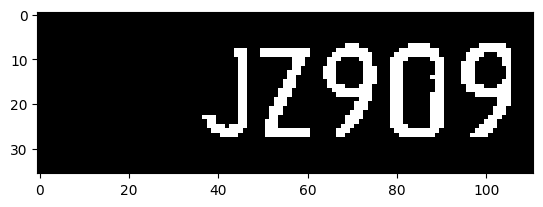

In [125]:
trainList = getTrainList()

dic = parseNameList(trainList)
kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1 , 0]])
kernel = np.ones((2,2))
for imgName in dic.keys():
    img = computeHomographie(imgName,dic)

    hauteur_Otsu,largeur_Otsu = img.shape
    histoOtsu = getHisto(img)/(hauteur_Otsu*largeur_Otsu)
    seuilOtsu = Otsu(histoOtsu)

    imgBin = binarize(img, seuilOtsu)
    imgBin = cv.morphologyEx(imgBin.astype('uint8'), cv.MORPH_OPEN, kernel.astype('uint8'))
    #print(imgName)
    #plt.imshow(imgBin)
    #plt.show()
    #Creation des profils horizontaux et verticaux
    hist = computeHorizontalProfil(imgBin)
    ioList = lookForColumnLetter(hist)
    #Localisation des lettres
    letters = lookForLetter(ioList,imgBin)
    saveImg(imgBin,imgName,letters,dic)